<h1>QQQ vs BTC</h1>
<br />
<p>This notebook assumes that you have a Python environment with the following additional modules</p>
<ul>
    <li>pandas_datareader</li>
    <li>cbpro</li>
</ul>

In [119]:
import time as epoch_time
import cbpro
import pandas_datareader.data as web
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import time
from datetime import date
from datetime import datetime
from datetime import timedelta
from scipy import stats
from scipy.stats.mstats import winsorize
sns.set()
sns.set_style('whitegrid')

start_date = date(2020, 10, 1)
end_date = date.today()

### Get QQ price time series

In [112]:
df = web.DataReader(name='QQQ', data_source='yahoo', start=start_date, end=end_date)
df = df.reset_index().drop_duplicates(subset='Date').set_index('Date')

### Check QQQ prices for outliers (3 sigma values) and winsorize if found

In [113]:
if np.any(stats.zscore(df['Adj Close']) > 3):
    print('Outliers detected, winsorizing...')
    df['Adj Close'] = winsorize(df['Adj Close'])

<h3>Get BTC price time series</h3>
<p>We must walk through time in chunks to avoid rate limits when requesting historical data</p>

In [ ]:
if isinstance(start_date, date):
    start_date = datetime.combine(start_date, time(0))

if isinstance(end_date, date):
    end_date = datetime.combine(end_date, time(0))
    
granularity = 60
walk_seconds = 200 * int(granularity)
partial_end = start_date + timedelta(0, walk_seconds)

data = []
public_client = cbpro.PublicClient()
print('Loading BTC historical data in chunks...')
while start_date < end_date:
    res = public_client.get_product_historic_rates(start=start_date, end=partial_end,
                                                   granularity=granularity, product_id='BTC-USD')
    if 'message' not in res and len(res) > 0:
        data += res
        start_date = partial_end
        partial_end += timedelta(0, walk_seconds)
        epoch_time.sleep(.25)
    else:
        print(f'{res}\nError, retrying...')

bf = pd.DataFrame(data=data, columns=['tmStamp', 'low', 'high', 'open', 'close', 'volume'])
bf['tmStamp'] = bf['tmStamp'].apply(lambda x: np.datetime64(
    epoch_time.strftime('%Y-%m-%d %H:%M:%S', epoch_time.localtime(x))))
bf.set_index('tmStamp', inplace=True)

### Check BTC prices for outliers and winsorize if found

In [135]:
if np.any(stats.zscore(bf['close']) > 3):
    print('Outliers detected, winsorizing...')
    bf['close'] = winsorize(bf['close'])

### Check the datetime frequency and resample accordingly

In [136]:
df['dt'] = df.index.date
xs = df.groupby('dt')['Close'].count()
if xs[xs > 1].shape[0] > 0:
    print('Datetime frequency greater than daily, downsample...')

In [137]:
cols = {'close': 'BTC'}
bf = bf.rename(columns=cols)[cols.values()]
bf['dt'] = bf.index.date
xs = bf.groupby('dt')['BTC'].count()
if xs[xs > 1].shape[0] > 0:
    print('Datetime frequency greater than daily, downsample...')
    xf = bf.resample('24h').mean().reset_index().rename(columns={'tmStamp': 'Date'})

Datetime frequency greater than daily, downsample...


### Merge the data

In [138]:
tf = pd.merge(df.reset_index().rename(columns={'Adj Close': 'QQQ'})[['Date', 'QQQ']], 
              xf, how='inner').set_index('Date')

### Generate the scatter plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


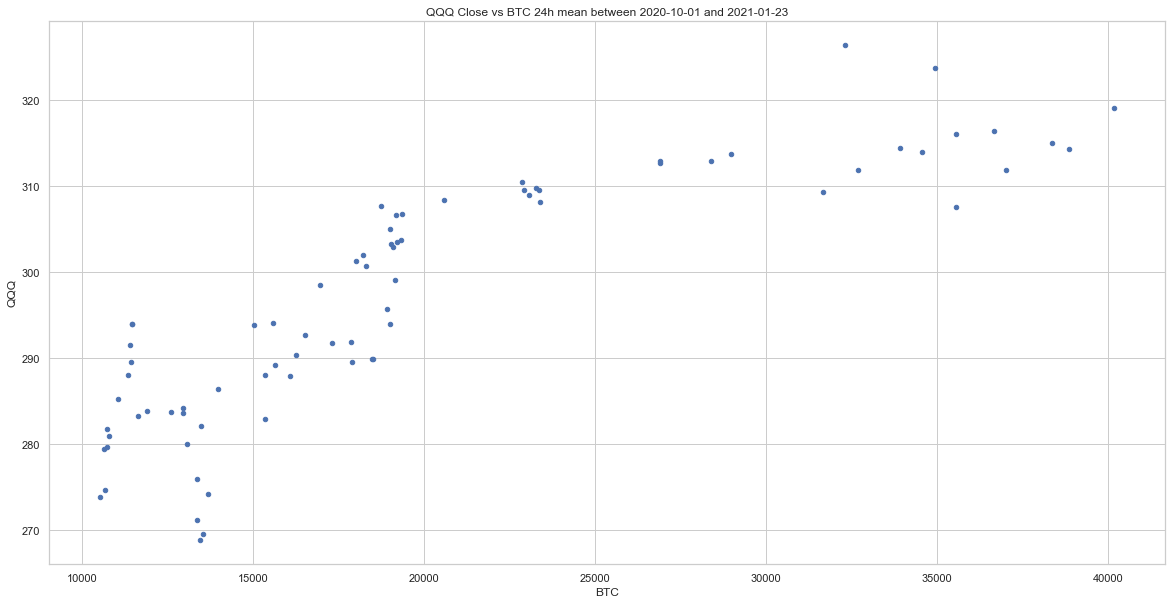

In [139]:
ax = tf.plot(x='BTC', y='QQQ', figsize=(20, 10), kind='scatter', title=f'QQQ Close vs BTC 24h mean between {start_date} and {end_date}')

### Overall correclation

In [140]:
corr = tf['QQQ'].corr(tf['BTC'])
print(f'Total period correlation is {corr:.2f}')

Total period correlation is 0.85


### Rolling 20 BD correlation

<AxesSubplot:title={'center':'QQQ / BTC rolling 20 BD correlation'}, xlabel='Date'>

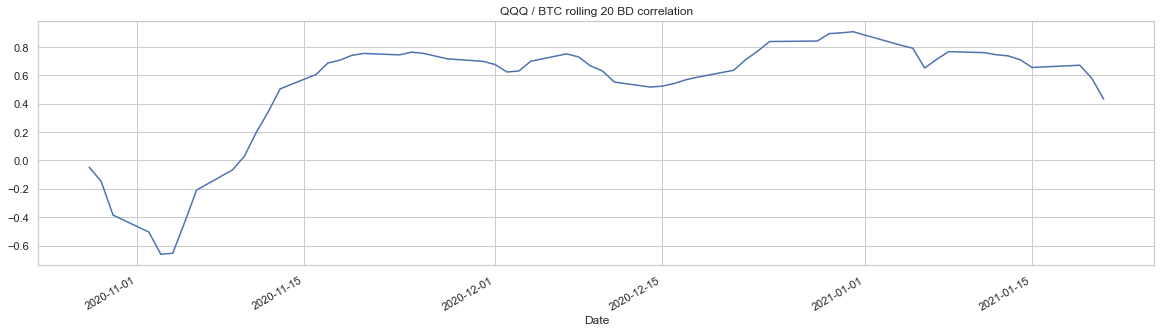

In [141]:
tf['QQQ'].rolling(20).corr(tf['BTC']).plot(figsize=(20, 5), title=f'QQQ / BTC rolling 20 BD correlation')